In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
from scipy import integrate
import os

In [4]:
us_confirmed = pd.read_csv('/Users/kulkarniad/corona/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv')
us_deaths = pd.read_csv('/Users/kulkarniad/corona/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv')


all_states = np.unique(us_confirmed.Province_State.values)
all_states = np.delete(all_states, np.argwhere(all_states == 'American Samoa'))
all_states = np.delete(all_states, np.argwhere(all_states == 'Diamond Princess'))
all_states = np.delete(all_states, np.argwhere(all_states == 'District of Columbia'))
all_states = np.delete(all_states, np.argwhere(all_states == 'Grand Princess'))
all_states = np.delete(all_states, np.argwhere(all_states == 'Guam'))
all_states = np.delete(all_states, np.argwhere(all_states == 'Northern Mariana Islands'))
all_states = np.delete(all_states, np.argwhere(all_states == 'Puerto Rico'))
all_states = np.delete(all_states, np.argwhere(all_states == 'Virgin Islands'))


In [12]:
def raw_data(state):
    df = us_confirmed[us_confirmed['Province_State'] == state]
    confirmed = df.sum(axis=0)
    confirmed = confirmed[11:] # skip metadata
    confirmed = pd.DataFrame(confirmed,columns=['confirmed'])
    
    df = us_deaths[us_deaths['Province_State'] == state]
    deaths = df.sum(axis=0)
    deaths = deaths[12:] # skip metadata
    deaths = pd.DataFrame(deaths,columns=['deaths'])
    
    df = pd.concat([confirmed,deaths], axis=1)
    
    
    df = df[(df.T != 0).any()] # start at the first confirmed case
    return df

def smooth_data(state,window = 14):
    df = raw_data(state)
    
    df.confirmed = df.confirmed.diff()
    df.deaths = df.deaths.diff()
    
    
    df = df.rolling(window=window,center=True,min_periods=window//2, win_type='gaussian').mean(std=window) # rolling mean window to smoothen out data
    df = df[window:].round()
    df = df.clip(lower = 1)
    return df

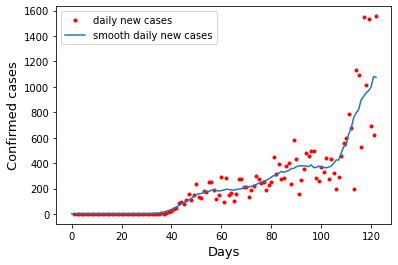

In [13]:
state_name = 'Arizona'
smoothing_window = 14
state = smooth_data(state_name,window=smoothing_window) # smoothened data with mean filter of 7 day
raw = raw_data(state_name)[smoothing_window:] # raw daily case and death counts 
plt.plot(np.arange(len(raw)),raw.confirmed.diff(), 'ro',markersize = 3,label = 'daily new cases')
plt.plot(np.arange(len(state)),state.confirmed,label = 'smooth daily new cases')
plt.xlabel('Days',fontsize = 13)
plt.ylabel('Confirmed cases',fontsize = 13)
plt.legend()

In [14]:
len(raw) == len(state)

True

In [15]:
smooth_data('Georgia')

,confirmed,deaths
3/17/20,54.0,2.0
3/18/20,71.0,2.0
3/19/20,87.0,3.0
3/20/20,106.0,3.0
3/21/20,138.0,4.0
...,...,...
6/6/20,676.0,28.0
6/7/20,695.0,29.0
6/8/20,692.0,28.0
6/9/20,678.0,26.0


In [16]:
# draw gamma from the appropriate log-normal distribution
def draw_gamma():
    s, loc, scale = 0.25,0,7
    gamma = stats.lognorm.rvs(s,loc,scale)
    return 1/gamma
    
def newcases(yesterday_cases,gamma,R):
    out = yesterday_cases
    out *= np.e**(gamma*(R-1))
    return out

# compute likelihood -> poisson
def r0_lhood(r0,gamma,yest_nc,today_nc,tol = 1e-6):
    prediction = newcases(yest_nc,gamma,r0)
    lhood = stats.poisson.logpmf(today_nc,prediction + tol)
    return lhood


def bayes_update(confirmed_vals,gamma,sigma=0.2):
    # Compute likelihoods
    likehoods = []
    for i in range(len(confirmed_vals)-1):
        yesterday = confirmed_vals[i]
        today = confirmed_vals[i+1]
        pmf = np.e**r0_lhood(r0_grid,gamma,yesterday,today)
        pmf /= np.sum(pmf)
        likehoods.append(pmf)
    likehoods = np.array(likehoods)
    
    
    # Process matrix add random perturbations the priors

    process_matrix = stats.norm(loc=r0_grid,scale=sigma).pdf(r0_grid[:, None]) 

   
    posteriors = []
    prior = np.ones(len(r0_grid))/len(r0_grid)

    for i in range(len(confirmed_vals) - 1):
        posterior = likehoods[i] * prior
        posterior /= np.sum(posterior)
        posteriors.append(posterior)   
        prior = process_matrix @ posterior

    posteriors = np.array(posteriors)
    
    return likehoods,posteriors


In [17]:
#define r0 grid
r0_grid = np.linspace(0,5,num=1000)


#define distribution for gamma
s, loc, scale = 0.25,0,7
gamma = stats.lognorm.rvs(s,loc,scale,size=10000)
gamma = 1/gamma

#smoothing window
smoothing_window = 14

In [18]:
for state_name in all_states:
    print(state_name)
    image_dir = 'images/'+state_name

    if (not os.path.exists(image_dir)):
        os.mkdir(image_dir)

    state = smooth_data(state_name,window=smoothing_window) # smoothened data with mean filter of 7 day
    raw = raw_data(state_name)[smoothing_window:] # raw daily case and death counts 

    likehoods = np.zeros((len(state) - 1,len(r0_grid)))
    posteriors = np.zeros((len(state) - 1,len(r0_grid)))

    draws = 1000
    for _ in range(draws):
        g = draw_gamma()
        l, p = bayes_update(state.confirmed.values,g)
        likehoods += l
        posteriors += p

    # Finally normlize again
    likehoods/= draws
    posteriors/= draws


    #Store data as a dictionary
    posterior_data = []
    for i in range(len(posteriors)):
        day = {'date':state.index[i+1],
              'likehood':likehoods[i],
              'posterior':posteriors[i]},

        posterior_data.append(day)


    np.save(image_dir+'/posterior_data.npy', posterior_data, allow_pickle=True)

Alabama
Alaska
Arizona
Arkansas
California
Colorado
Connecticut
Delaware
Florida
Georgia
Hawaii
Idaho
Illinois
Indiana
Iowa
Kansas
Kentucky
Louisiana
Maine
Maryland
Massachusetts
Michigan
Minnesota
Mississippi
Missouri
Montana
Nebraska
Nevada
New Hampshire
New Jersey
New Mexico
New York
North Carolina
North Dakota
Ohio
Oklahoma
Oregon
Pennsylvania
Rhode Island
South Carolina
South Dakota
Tennessee
Texas
Utah
Vermont
Virginia
Washington
West Virginia
Wisconsin
Wyoming
